In [ ]:
# !python -m venv venv
# # !venv/scripts/activate
%pip install pandas numpy matplotlib seaborn plotly geopandas scipy scikit-learn statsmodels requests aiohttp shapely ipython h3 ipywidgets dtale

In [1]:
# Data Manipulation
import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

import requests
import os

import datetime as dt
import time

from pandas import read_csv
import concurrent.futures
import psutil

from datetime import datetime

import h3
import geopandas as gpd
import shapely
import plotly.express as px


In [17]:
# hexagon map
def get_hexagon_grid(latitude, longitude, resolution, ring_size):
    """
    Generate a hexagonal grid GeoDataFrame centered around a specified location.
    Parameters:
    - latitude (float): Latitude of the center point.
    - longitude (float): Longitude of the center point.
    - resolution (int): H3 resolution for hexagons.
    - ring_size (int): Number of rings to create around the center hexagon.
    Returns:
    - hexagon_df (geopandas.GeoDataFrame): GeoDataFrame containing hexagons and their geometries.
    """

    # Get the H3 hexagons covering the specified location
    center_h3 = h3.geo_to_h3(latitude, longitude, resolution)
    hexagons = list(h3.k_ring(center_h3, ring_size))  # Convert the set to a list

    # Create a GeoDataFrame with hexagons and their corresponding geometries
    hexagon_geometries = [shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
    hexagon_df = gpd.GeoDataFrame({'Hexagon_ID': hexagons, 'geometry': hexagon_geometries})

    return hexagon_df


# Latitude and longitude coordinates
home_lat = 1.3472764
home_lng = 103.9104234

# Generate H3 hexagons at a specified resolution (e.g., 9)
resolution = 5

# Indicate the number of rings around the central hexagon
ring_size = 463

# Hexagon grid around HOME
hexagon_df = get_hexagon_grid(home_lat, home_lng, resolution, ring_size)



In [ ]:
# Verify that the hexagon grid is suitable
# create_choropleth_map_only_hexagon_df(geojson_df=hexagon_df)

# def create_choropleth_map_only_hexagon_df(geojson_df, alpha=0.1, map_style="carto-positron", color_scale="Viridis"):
#     """
#     Create an interactive choropleth map using Plotly Express.
#     Parameters:
#     - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
#     - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
#     - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
#     - color_scale (str): Color scale for the choropleth map.
#     Returns:
#     None
#     """
#     # Create a choropleth map using px.choropleth_mapbox
#     fig = px.choropleth_mapbox(
#         geojson_df,
#         geojson=geojson_df.geometry,
#         locations=geojson_df.index,  # Use index as locations to avoid duplicate rows
#         # color="Count",
#         color_continuous_scale=color_scale,
#         title="GPS Jam Map",
#         mapbox_style=map_style,
#         center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
#         zoom=2,
#     )

#     # Customize the opacity of the hexagons
#     fig.update_traces(marker=dict(opacity=alpha))

#     # Set margins to 25 on all sides
#     fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
#     # Adjust the width of the visualization
#     fig.update_layout(width=1000) 

#     fig.show()

In [ ]:
def calculate_hexagon_ids(df):
    """
    Calculate Hexagon IDs for each row(ping) in a DataFrame based on their geographic coordinates.
    Args:
        df (pd.DataFrame): DataFrame containing ADSB data with "lat" and "lon" columns.
        hexagon_df (gpd.GeoDataFrame): GeoDataFrame with hexagon geometries and associated Hexagon IDs.
    Returns:
        pd.DataFrame: The input DataFrame with an additional "Hexagon_ID" column indicating the Hexagon ID for each ping.
    """

    # Create a column Hexagon_ID with the ID of the hexagon
    df['Hexagon_ID'] = None

    # Iterate through the hotels in the df DataFrame and calculate hotel counts within each hexagon
    for i, ping in df.iterrows():
        if not isinstance(ping['lat'], float):
            continue  
        resolution=5   
        result = h3.geo_to_h3(ping["lat"], ping["lon"], resolution)
        # print(f'{ping["lat"]},{ping["lon"]}=>{result}')
        if result != 0:
             df.loc[i, 'Hexagon_ID'] = result
    
    return df

def time_elapsed(start_time):
    end_time = time.time()
    return end_time - start_time

time_data={
    "pickle": 0,
    "url": 0,
    "concat": 0,
}

def get_adsb_data(data):
    response = requests.get(data["url"])
    print(f"downloaded {data['url']}")
    json_data = response.json()
    
    utc_time = dt.datetime.fromtimestamp(json_data['now'])
    df = pd.json_normalize(json_data['aircraft'])

    df = df[df["type"] == 'adsb_icao']
    df['time'] = datetime.strftime(utc_time.timestamp(),"%Y%m%D%H%M%S")
    df['good_bad'] = df['nic'].apply(lambda x: 'good' if x >= 7 else 'bad')
    df1['alt_baro'] = df1['alt_baro'].apply(lambda x: 0 if (x.lower() == "ground" or x == "Nan values" ) else float(x))
    df1["nic"] = df1['nic'].apply(lambda x: int(float(x)) if x !="Nan values" else 0)


    df['Hexagon_ID'] = None
    df = df[['time','Hexagon_ID','hex','lat','lon','alt_baro','nic','type', 'flight', 'r', 't', 'category', 'version', 'nac_p', 'nac_v','good_bad' ]]
    df = df.fillna("Nan values")
    df = df.map(lambda x: ', '.join(x) if isinstance(x, list) else x)

    df = calculate_hexagon_ids(df)

    #save to pickle
    if not os.path.exists(os.path.dirname(data["csv"])):
        os.makedirs(os.path.dirname(data["csv"]))
    df.to_csv(data["csv"])
    return df

def download_data(index, data, length_data_array, start_time_overall):
    start_time = time.time()

    try:
        # if pickle exists, do nothing
        if (os.path.isfile(data["csv"])):
            print(f"csv exists {data['csv']}")
            return
        else:
            get_adsb_data(data)

            time_data["url"] += time_elapsed(start_time)

            remaining_time = (time.time() - start_time_overall)/(index+1) * (length_data_array - index)
            print(f"Remaining execution time: {remaining_time//60:.0f}m {remaining_time%60:.0f}s")

            return

    except Exception as e:
        # Handle other exceptions
        print("An error occurred:", e)

def join_large_csv(folder_path,start,end,file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    isHeader = True
    with open(file_path, 'w') as outfile:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            file_datetime = datetime.strptime(file_path, 'csv\\%Y%m%d\\%H%M%SZ.csv')
            print(file_datetime)
            # csv_path = os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.csv')
            if filename.endswith('.csv') and start <= file_datetime and file_datetime <= end:
                with open(file_path, 'r') as infile:
                    # skip row header
                    if isHeader:
                        outfile.write(infile.read())
                        isHeader = False
                    else:
                        outfile.write(''.join(infile.readlines()[1:]))
                print(f'Joined {file_path}')

def load_data(start_date_time,end_date_time, reload=False):
    delta = dt.timedelta(seconds=5)
    start = start_date_time
    df1 = None
    df2 = None
    csv_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}joined.csv')
    hexbin_path = os.path.join('csv', 'hexbin', f'{start_date_time.strftime("%Y%m%d")}hexbin.csv')

    if not reload:

        data_array = []
        while start < end_date_time:
            data_array.append({
                "url": f'https://samples.adsbexchange.com/readsb-hist/{start.strftime("%Y/%m/%d")}/{start.strftime("%H%M%S")}Z.json.gz',
                "pickle": os.path.join('pickle',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.pkl'),
                "csv": os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.csv')
                })
            start += delta

        report1=""
        report2=""

        start_time_overall = time.time()

        with concurrent.futures.ThreadPoolExecutor() as executor:
            l = [len(data_array)] * len(data_array)
            list(executor.map(lambda i: download_data(i, data_array[i], l[i], start_time_overall), range(len(data_array))))
            report1 = get_memory_usage()

        join_large_csv(os.path.join('csv',start_date_time.strftime("%Y%m%d")),start_date_time,end_date_time,csv_path)

        start_time_overall = time.time()
        print(f"Download memory usage\n{report1}\n\n")
        print(f"CSV memory usage\n{report2}")
        # only when all the threads are complete, then concat happens
        print(f'Total directory size: {get_directory_size("csv"):.1f} MB')
        print(f"Download time: {(time_data['url']/3600):.1f} min")
        print(f"CSV time: {(time_data['pickle']/3600):.1f} min")
    
    df1 = read_csv(csv_path)

    if not reload:

        df2 = df1.groupby(['Hexagon_ID'], as_index=False).agg(good_count=('good_bad', lambda x: (x == 'good').sum()),
                                                bad_count=('good_bad', lambda x: (x == 'bad').sum()))
        df2['bad_count'] = df2['bad_count'].apply(lambda x: 0 if x == 1 else x)
        df2 = df2.assign(percentage_bad=df2['bad_count'] / (df2['good_count'] + df2['bad_count']))

        def get_lat(row):
            return h3.h3_to_geo(row['Hexagon_ID'])[0]

        def get_lng(row):
            return h3.h3_to_geo(row['Hexagon_ID'])[1]

        # Apply the function to create new 'lat' and 'lng' columns
        df2['lat'] = df2.apply(get_lat, axis=1)
        df2['lng'] = df2.apply(get_lng, axis=1)

        df2.to_csv(hexbin_path)
    
    else:
        df2 = read_csv(hexbin_path)

    return [df1, df2]


def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
            total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

def get_memory_usage():

    # Get the memory usage
    memory_usage = psutil.virtual_memory()

    # Print the memory usage
    report = f"""
        Total Memory: {memory_usage.total / (1024 ** 3):.2f} GB
        Available Memory: {memory_usage.available / (1024 ** 3):.2f} GB
        Used Memory: {memory_usage.used / (1024 ** 3):.2f} GB
        Memory Usage Percentage: {memory_usage.percent:.2f}%
    """
    return report

# note that for the free sample, only the first day of each month is available on the adsbexchange
# 4 hours + to download 1 day of files
# 18 mins to reload

[df1,df2] = load_data(dt.datetime(2024,6,1,0,0,0),dt.datetime(2024,6,2,0,0,0), reload=False)
df2[df2['percentage_bad'] > 0].head(10)


In [14]:
df1 = read_csv("csv\\joined\\20240601joined.csv")

# df1["time"] = df1['time'].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),"%Y%m%d%H%M%S"))
df1["nic"] = df1['nic'].apply(lambda x: int(float(x)) if x !="Nan values" else 0)
df1['good_bad'] = df1['nic'].apply(lambda x: False if x=="Nan values" or int(x)<=6 else True)
df1['alt_baro'] = df1['alt_baro'].apply(lambda x: 0 if (x == "ground" or x == "Nan values" ) else int(x))

bad_flights = df1[df1["nic"]<7]["r"]
print(len(bad_flights))
df1_bad = df1[df1["r"].isin(bad_flights)]
df1_bad.to_csv("csv\\joined\\20240601bad.csv")
df1.to_csv("csv\\joined\\20240601joined-2.csv")

4224570


    Unnamed: 0       Hexagon_ID  good_count  bad_count  percentage_bad  \
0            0  8500c82bfffffff           0         16             1.0   
1            1  8500c863fffffff           0         17             1.0   
2            2  8500c86bfffffff           0          4             1.0   
4            4  8500cb83fffffff           0          4             1.0   
5            5  85010423fffffff          15          0             0.0   
6            6  8501042bfffffff          14          0             0.0   
7            7  85010437fffffff          10          0             0.0   
8            8  85010463fffffff          11          0             0.0   
9            9  85010467fffffff          10          0             0.0   
10          10  8501046bfffffff          14          0             0.0   

          lat         lng  total_count  
0   87.771119  115.526548           16  
1   87.495317  114.186263           17  
2   87.343395  115.352392            4  
4   87.689886  123.47

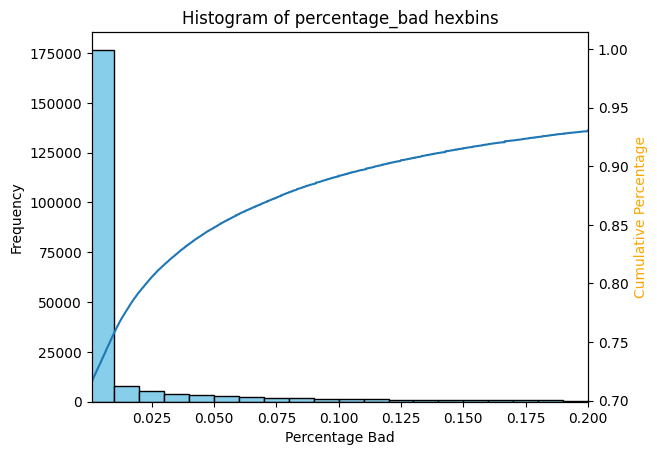

Hexbin with high good count is likely a strong GPS signal and no jamming
Hex bin with large sample size (total count) has high confidence


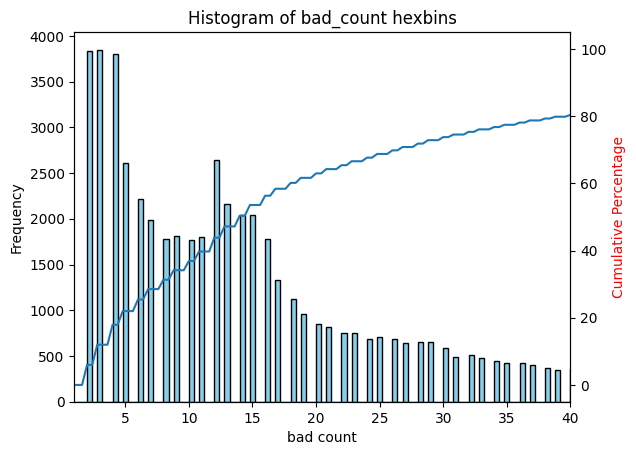

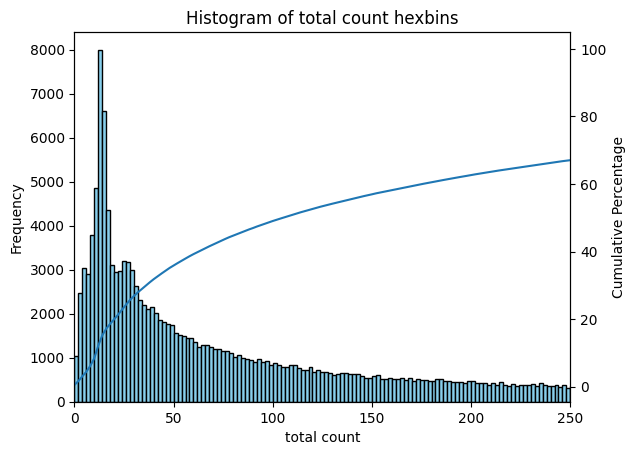

In [16]:
df2 = read_csv("csv\\hexbin\\20240601hexbin.csv")
df2['total_count'] = df2['good_count'] + df2['bad_count']

df2_bad = df2.query('percentage_bad>=0.0 & percentage_bad<=1')
print(df2_bad.head(10))
print(df2_bad.shape[0])
print(f"{df2_bad.shape[0]/df2.shape[0]:.3f} bad hexbins")
# df2_bad['percentage_bad'].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
# plt.title('Histogram of percentage_bad hexbins')
# plt.xlabel('Percentage Bad')
# plt.ylabel('Frequency')
# plt.show()
fig, ax1 = plt.subplots()
ax1.hist(df2_bad['percentage_bad'], bins=100, color='skyblue', edgecolor='black')
ax1.set_title('Histogram of percentage_bad hexbins')
ax1.set_xlabel('Percentage Bad')
ax1.set_ylabel('Frequency')

ax2 = ax1.twinx()
cumulative_percentage = df2_bad['percentage_bad'].value_counts(normalize=True).sort_index().cumsum()
ax2.plot(cumulative_percentage.index, cumulative_percentage.values, '-')
ax2.set_ylabel('Cumulative Percentage', color='orange')
plt.xlim(0.001,0.2)

plt.show()

print("Hexbin with high good count is likely a strong GPS signal and no jamming")
print("Hex bin with large sample size (total count) has high confidence")
# df2['good_count'].plot(kind='hist', bins=10000, color='skyblue', edgecolor='black')
# plt.xlim(0,2000)
# plt.title('Histogram of good_count hexbins')
# plt.xlabel('good count')
# plt.ylabel('Frequency')
# plt.show()

# df2['bad_count'].plot(kind='hist', bins=10000, color='skyblue', edgecolor='black')
# plt.xlim(0,80)
# plt.title('Histogram of bad_count hexbins')
# plt.xlabel('bad count')
# plt.ylabel('Frequency')
# plt.show()

n, bins, patches = plt.hist(df2[df2['bad_count']>0]['bad_count'], bins=500, range=(0,200), color='skyblue', edgecolor='black')
plt.xlim(1, 40)
plt.title('Histogram of bad_count hexbins')
plt.xlabel('bad count')
plt.ylabel('Frequency')

# Calculate the cumulative percentage
cumulative = 100 * n.cumsum() / n.sum()

# Create the second y-axis for the cumulative percentage
ax2 = plt.twinx()
ax2.plot(bins[:-1], cumulative, '-')
ax2.set_ylabel('Cumulative Percentage', color='red')
plt.show()

# df2['total_count'].plot(kind='hist', bins=100000, color='skyblue', edgecolor='black')
# plt.xlim(0,2000)
# plt.title('Histogram of total count hexbins')
# plt.xlabel('total count')
# plt.ylabel('Frequency')
# plt.show()

n, bins, patches = plt.hist(df2['total_count'], bins=1000, range=(0,2000), color='skyblue', edgecolor='black')
plt.xlim(0, 250)
plt.title('Histogram of total count hexbins')
plt.xlabel('total count')
plt.ylabel('Frequency')

# Calculate the cumulative percentage
cumulative = 100 * n.cumsum() / n.sum()

# Create the second y-axis for the cumulative percentage
ax2 = plt.twinx()
ax2.set_ylabel('Cumulative Percentage')
ax2.plot(bins[:-1], cumulative, '-')

plt.show()


In [17]:
print(f"{df1.shape[0]} rows")


158237549 rows


In [16]:
print(f"{df1_bad.shape[0]} rows")
df1_bad.head(10)

151549288 rows


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,Hexagon_ID,hex,lat,lon,alt_baro,nic,type,flight,r,t,category,version,nac_p,nac_v,good_bad
0,0,0,0,20240601075959,850ca233fffffff,c0173a,62.187831,-172.862478,34000,8,adsb_icao,ACA5,C-FIUR,B77W,A3,2.0,10.0,2.0,True
1,1,1,3,20240601075959,850ca033fffffff,aaa4dc,62.821655,-171.065369,35000,8,adsb_icao,UAL803,N785UA,B772,A5,2.0,10.0,2.0,True
2,2,2,4,20240601075959,850ca0affffffff,71ba03,62.915722,-170.707785,32000,8,adsb_icao,KAL038,HL7203,B77W,A5,2.0,9.0,1.0,True
3,3,3,5,20240601075959,850ca0affffffff,c02ebd,62.945515,-170.615457,38000,8,adsb_icao,ACA1,C-FRSE,B789,A5,2.0,9.0,2.0,True
4,4,4,6,20240601075959,850ca567fffffff,868078,63.214554,-169.761587,34000,8,adsb_icao,JAL9,JA739J,B77W,A5,2.0,10.0,2.0,True
5,5,5,7,20240601075959,850c8d7bfffffff,86eb36,58.754791,-167.594575,39000,0,adsb_icao,JAL1,JA882J,B789,A5,2.0,9.0,Nan values,False
6,6,6,9,20240601075959,850ca95bfffffff,86d9f4,60.619308,-166.267753,38975,8,adsb_icao,ANA101,JA837A,B789,A5,2.0,9.0,1.0,True
7,7,7,10,20240601075959,850cad73fffffff,a4db4e,61.462966,-165.760701,2850,9,adsb_icao,N4118G,N4118G,PA31,A1,2.0,10.0,2.0,True
8,8,8,11,20240601075959,850cf60bfffffff,a31a54,59.555488,-165.468497,37975,8,adsb_icao,UAL143,N29975,B789,A5,2.0,9.0,2.0,True
9,9,9,12,20240601075959,850cad77fffffff,a4d881,61.392883,-165.38887,2875,9,adsb_icao,N411GV,N411GV,C208,A1,2.0,10.0,2.0,True


In [5]:
df1.to_csv("csv\\joined\\20240601joined.csv")

In [ ]:
df1.head(100)

In [ ]:
df2.head(10)

In [ ]:
# https://towardsdatascience.com/3-python-packages-for-interactive-data-analysis-3063a201a589
# https://towardsdatascience.com/4-libraries-that-can-perform-eda-in-one-line-of-python-code-b13938a06ae

In [ ]:
bad_flights = df1[df1["good_bad"] == "bad"]["r"].unique()
print(f"bad flights {len(bad_flights)}")

bad_hexagons = df2[df2["percentage_bad"]>0]["Hexagon_ID"].unique()
print(f"bed hexagons {len(bad_hexagons)}")

bad_flights_df = df1[df1["r"] == bad_flights[0]]

print(bad_flights_df.head(10))
print(len(bad_flights_df))

In [ ]:
# plt.figure(figsize=(12, 12))
# plt.plot(df1['time'], df1['alt_baro'], 'b-',  label='alt_baro')
# plt.plot(df1['time'], df1['nic'], 'rx', label='nic', color='orange')
# plt.xlabel('Time')
# plt.ylabel('Altitude (ft) / NIC')
# plt.title('Altitude and NIC vs Time')
# plt.legend()
# plt.show()

# bad_flights_df['nic'].apply(lambda x: 0 if (x == "Nan values") else float(x))
# bad_flights_df['alt_baro'].apply(lambda x: 0 if (x.lower() == "ground" or x == "Nan values" ) else float(x))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(bad_flights_df['time'], bad_flights_df['alt_baro'], 'b-', label='alt_baro')
ax1.set_xlabel('Time')
ax1.set_ylabel('Altitude (ft)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_yticks(np.arange(0, 50000, 5000))
start_time = datetime.timestamp(dt.datetime(2024,6,1,12,0,0))
end_time = datetime.timestamp(dt.datetime(2024,6,1,14,0,0))
xticks = np.arange(start_time, end_time, 3600)
xticksminor=np.arange(start_time, end_time, 900)
xticksminor=xticksminor[xticksminor//3600!=0]
# for i in np.arange(start_time, end_time, 900)]
xlabels = [f"{datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S')}" for x in xticks]
xlabelsminor = [f"{datetime.strftime(datetime.fromtimestamp(x), '%H:%M:%S')}" for x in xticksminor]

    #    ax.set_yticks(np.arange(0, 100.1, 100/3))
    #     ax.set_yticks(np.arange(0, 100.1, 100/30), minor=True)
ax1.set_xticks(xticks, labels=xlabels, rotation=90, fontsize=10)
ax1.set_xticks(xticksminor, labels=xlabelsminor, rotation=90, fontsize=10, minor=True)
ax1.tick_params('x', labelbottom='True')
plt.xlim((start_time, end_time))


ax2 = ax1.twinx()
ax2.plot(bad_flights_df['time'], bad_flights_df['nic'], 'rx', label='nic', color='g')
ax2.set_ylabel('NIC', color='g')
ax2.tick_params('y', colors='g')
ax2.set_yticks(np.arange(0, 14, 1))


plt.title('Altitude and NIC vs Time')
fig.legend(loc="upper right")
plt.show()


In [ ]:
def create_choropleth_map(geojson_df, data_df, alpha=0.3, map_style="carto-positron"):
    """
    Create an interactive choropleth map using Plotly Express.
    Parameters:
    - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
    - data_df (DataFrame): DataFrame containing data to be visualized on the map.
    - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
    - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
    - color_scale (str): Color scale for the choropleth map.
    Returns:
    None
    """
    # Merge the GeoJSON data with your DataFrame
    merged_df = geojson_df.merge(data_df, on="Hexagon_ID", how="left")

    # Create a choropleth map using px.choropleth_mapbox
    fig = px.choropleth_mapbox(
        merged_df,
        geojson=merged_df.geometry,
        locations=merged_df.index,  # Use index as locations to avoid duplicate rows
        color="percentage_bad",
        color_continuous_scale=[[0, f'rgba(0,255,0,{alpha})'],
                                [0.02, f'rgba(255,255,0,{alpha})'],
                                [0.10, f'rgba(255,0,0,{alpha})'],
                                [1, f'rgba(255,0,0,{alpha})']],        
        title="GPS Jam Map",
        mapbox_style=map_style,
        center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
        zoom=2,
    )

    # Customize the opacity of the hexagons
    fig.update_traces(marker=dict(opacity=alpha))

    # Add hover data for hotel names
    fig.update_traces(customdata=merged_df[["Hexagon_ID","bad_count", "total_count", "percentage_bad", "lat", "lng"]])

    # Define the hover template 
    hover_template = "<b>Location:</b> %{customdata[3]:.4f},%{customdata[4]:.4f}<br><b>Bad Count:</b> %{customdata[0]}<br><b>Good Count:</b> %{customdata[1]}<br><b>Percentage Bad:</b> %{customdata[2]:.2f}<br><extra></extra>"
    fig.update_traces(hovertemplate=hover_template)

    # Set margins to 25 on all sides
    fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
    # Adjust the width of the visualization
    fig.update_layout(width=1000) 

    fig.show()


In [ ]:
create_choropleth_map(geojson_df=hexagon_df, data_df=df2)

In [ ]:
# Change in NIC/NAC/SIL indicates an anomaly, which may be due to any reason

# nic: Navigation Integrity Category (2.2.3.2.7.2.6)
# Table 1: NIC value and corresponding size of containment radius
# NIC Containment Radius
# 0 Unknown
# 1 Rc < 37.04km (20nm)
# 2 Rc < 14.816km (8nm)
# 3 Rc < 7.408km (4nm)
# 4 Rc < 3.704km (2nm)
# 5 Rc < 1852m (1nm)
# 6 Rc < 1111.2m (0.6nm)
# Rc < 926m (0.5nm)
# Rc < 555.6m (0.3nm)
# 7 Rc < 370.4m (0.2nm)
# 8 Rc < 185.2m (0.1nm)
# 9 Rc < 75m
# 10 Rc < 25m
# 11 Rc < 7.5m

# Assuming you have already calculated the counts
# counts = df1['nic'].value_counts(dropna=False)
# print(f"List all nic values with counts {counts}")
# # Create bins for the histogram
# bins = np.arange(len(counts) + 1)

# # Plot the histogram with NA on the left
# plt.hist(df1['nic'], bins=bins, align='left',rwidth=0.5)
# plt.yscale('log')
# plt.title('nic')
# plt.show()

print(f"bad {df1[df1['good_bad']=='bad'].shape[0]}")
print(f"total {df1.shape[0]}")
print(f"% bad / total {df1[df1['good_bad']=='bad'].shape[0]/df1.shape[0]*100:.2f}%")
df1[df1['good_bad']=='bad'].head(100)

In [ ]:
print(f"List all type with counts {df1['type'].value_counts()}")
# List all type with counts type
# adsb_icao         9145 - messages from a Mode S or ADS-B transponder, using a 24-bit ICAO address
# other              725 - IGNORE miscellaneous data received via Basestation / SBS format, quality / source is unknown.
# adsb_icao_nt       524 - IGNORE - messages from an ADS-B equipped “non-transponder” emitter e.g. a ground vehicle, using a 24-bit ICAO address
# mode_s             515 - ModeS data from the planes transponder (no position transmitted)
# adsr_icao          280 - rebroadcast of ADS-B messages originally sent via another data link e.g. UAT, using a 24-bit ICAO address
# tisb_other         256 - traffic information about a non-ADS-B target using a non-ICAO address
# tisb_trackfile     214 - traffic information about a non-ADS-B target using a track/file identifier, typically from primary or Mode A/C radar
# mlat               116 - MLAT, position calculated arrival time differences using multiple receivers, outliers and varying accuracy is expected.
# unknown             49
# tisb_icao           31 - traffic information about a non-ADS-B target identified by a 24-bit ICAO address, e.g. a Mode S target tracked by secondary radar
# adsb_other          17 - messages from an ADS-B transponder using a non-ICAO address, e.g. anonymized address
plt.hist(df1['type'], align='left')
plt.title('type')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:

df1_filtered = df1[df1[['nac_p','nac_v']].notnull().all(1)]
nacp_high = df1_filtered[df1_filtered['nac_p']<8]
nacp_high
# rr_lat not null
# rr_lon not null
# lastPosition.lat / lastPosition.lon not null

In [ ]:
print(f"List all ADSB versions with counts {df1['version'].value_counts()}")
# version: ADS-B Version Number 0, 1, 2 (3-7 are reserved) (2.2.3.2.7.5)
# List all ADSB versions with counts version
# 2.0    8881
# 0.0    1119
# 1.0     141
plt.hist(df1['version'])
plt.title('version')
plt.show()

In [ ]:
# nac_p: Navigation Accuracy for Position (2.2.5.1.35)
counts = df1['nac_p'].value_counts()
print(f"List all nac_p values with counts {counts}")
plt.hist(df1['nac_p'])
plt.title('nac_p')
plt.show()

In [ ]:
# nac_v: Navigation Accuracy for Velocity (2.2.5.1.19)
counts = df1['nac_v'].value_counts()
print(f"List all nac_v values with counts {counts}")
plt.hist(df1['nac_v'])
plt.title('nac_v')
plt.show()

In [ ]:
# roll: Roll, degrees, negative is left roll
counts = df1['roll'].value_counts()
print(f"List all roll with counts {counts}")
plt.hist(df1['roll'], align='left')
plt.title('roll')
plt.show()

In [ ]:
# category: emitter category to identify particular aircraft or vehicle classes (values A0 – D7) (2.2.3.2.5.2)
counts = df1['category'].dropna()
# print(f"List all category with counts {counts}")
plt.hist(counts)
plt.title('category')
plt.show()
# A0 : No ADS-B emitter category information. Do not use this emitter category. If no emitter category fits your installation, seek guidance from the FAA as appropriate. A1 : Light (< 15500 lbs) – Any airplane with a maximum takeoff weight less than 15,500 pounds. This includes very light aircraft (light sport aircraft) that do not meet the requirements of 14 CFR § 103.1.
# A2 : Small (15500 to 75000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to15,500 pounds but less than 75,000 pounds.
# A3 : Large (75000 to 300000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that does not qualify for the high vortex category.
# A4 :  High vortex large (aircraft such as B-757) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that has been determined to generate a high wake vortex. Currently, the Boeing 757 is the only example.
# A5 : Heavy (> 300000 lbs) – Any airplane with a maximum takeoff weight equal to or above 300,000 pounds.
# A6 : High performance (> 5g acceleration and 400 kts) – Any airplane, regardless of weight, which can maneuver in excess of 5 G’s and maintain true airspeed above 400 knots.
# A7 : Rotorcraft – Any rotorcraft regardless of weight.
# B0 : No ADS-B emitter category information
# B1 : Glider / sailplane – Any glider or sailplane regardless of weight.
# B2 : Lighter-than-air – Any lighter than air (airship or balloon) regardless of weight.
# B3 : Parachutist / skydiver
# B4 : Ultralight / hang-glider / paraglider – A vehicle that meets the requirements of 14 CFR § 103.1. Light sport aircraft should not use the ultralight emitter category unless they meet 14 CFR § 103.1.
# B5 : Reserved
# B6 : Unmanned aerial vehicle – Any unmanned aerial vehicle or unmanned aircraft system regardless of weight.
# B7 : Space / trans-atmospheric vehicle
# C0 : No ADS-B emitter category information
# C1 : Surface vehicle – emergency vehicle
# C2 : Surface vehicle – service vehicle
# C3 : Point obstacle (includes tethered balloons)
# C4 : Cluster obstacle
# C5 : Line obstacle
# C6 : Reserved
# C7 : Reserved

In [ ]:
counts = df1['sil'].value_counts(dropna=False)

print(f"List all sil values with counts {counts}")
# Create bins for the histogram
bins = np.arange(len(counts) + 1)

# Plot the histogram with NA on the left
plt.hist(df1['sil'], bins=bins, align='left',rwidth=0.5)
plt.yscale('log')
plt.title('sil')
plt.show()

In [ ]:
url2 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000005Z.json.gz'
response2 = requests.get(url2)
json_data2 = response2.json()
df2 = pd.json_normalize(json_data2['aircraft'])
url3 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000010Z.json.gz'
response3 = requests.get(url3)
json_data3 = response2.json()
df3 = pd.json_normalize(json_data3['aircraft'])
url4 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000015Z.json.gz'
response4 = requests.get(url4)
json_data4 = response2.json()
df4 = pd.json_normalize(json_data4['aircraft'])